# Week 07 Exercises 

### 7.1 Calculating the Normalized Difference Index
From [https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index](https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index)... the Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion: 

(NIR - R) / (NIR + R)

NDVI always ranges from -1 to +1. But there isn’t a distinct boundary for each type of land cover.For example, when you have negative values, it’s highly likely that it’s water. On the other hand, if you have an NDVI value close to +1, there’s a high possibility that it’s dense green leaves. But when NDVI is close to zero, there are likely no green leaves and it could even be an urbanized area.

For this first exercise you will calculate NDVI over the LMU campus.

1. Load both red (``` 'data/2023-02-22-sentinel-2-red-band.tiff' ```) and NIR (``` 'data/2023-02-22-sentinel-2-NIR-band.tiff' ```) bands from images taken from Sentinel-2 satellite over the LMU campus on February 22, 2023. Make sure when loading to use ```masked=True ```. Why do we want to do this? Check to see if the bounds, resolution and CRS are the same for both datasets. 

2. Calculate the NDVI. Export and save to a file as ``` 'data/2023-02-22-sentinel-2-NDVI.tiff' ```

3. Plot the NDVI data using the colormap ```RdYlGn```. Write 1-2 sentences describing patterns you notice.

4. Create a histogram with the custom bins: ```  bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1] ```. Write 1-2 sentences explaining patterns you notice. Lastly, print the max and min values. 

In [33]:
#import packages
import os

import numpy as np
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping

In [34]:
red_band = rxr.open_rasterio('data/2023-02-22-sentinel-2-red-band.tiff', masked=True).squeeze()
red_band

<xarray.DataArray (y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
NIR_band = rxr.open_rasterio('data/2023-02-22-sentinel-2-NIR-band.tiff', masked=True).squeeze()
NIR_band

<xarray.DataArray (y: 140, x: 159)>
[22260 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -118.4 -118.4 -118.4 ... -118.4 -118.4 -118.4
  * y            (y) float64 33.98 33.97 33.97 33.97 ... 33.96 33.96 33.96 33.96
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

**We want to mark masked = true because we want to identify the regions of valid data values.**

In [68]:

print("Is the spatial extent the same?",
      NIR_band.rio.bounds() == red_band.rio.bounds())

print("Is the resolution the same?",
      NIR_band.rio.resolution() == red_band.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


In [36]:
#Calculate NDVI
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (NIR_band.astype(float) - red_band.astype(float)) / (NIR_band + red_band)

In [37]:
# Create the file
ndvi.rio.to_raster("2023-02-22-sentinel-2-NDVI.tiff")
        
        #'data/2023-02-22-sentinel-2-NDVI.tiff'

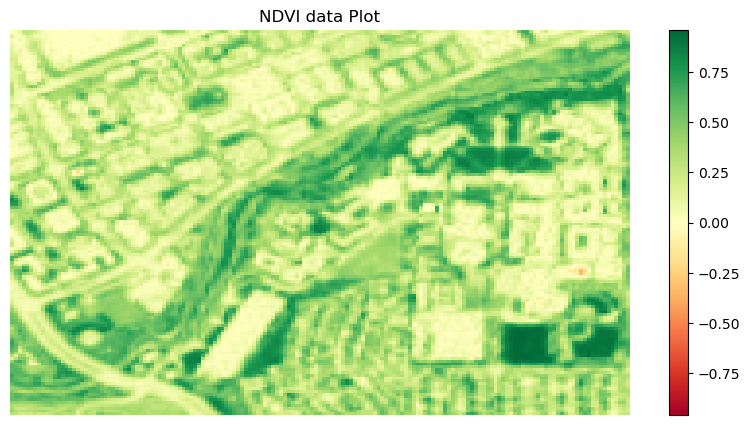

In [38]:
f, ax = plt.subplots(figsize=(10, 5))
ndvi.plot(cmap="RdYlGn")
ax.set(title="NDVI data Plot")
ax.set_axis_off()
plt.show()

**I notice that there is a majority of green and beige coloring, however, everything demonstrated here has a green tint to it. It is harder to distinguish which sections are vegetation and which sections are buildings if the maps image wasn't laid behind it**

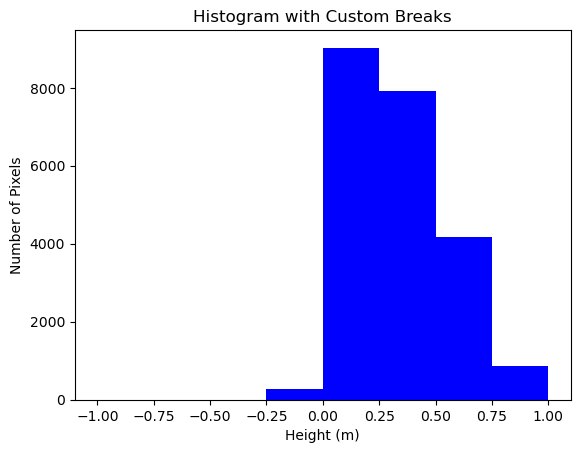

In [39]:
#Create Histogram
f, ax = plt.subplots()
ndvi.plot.hist(color="blue",
                        bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

I notice that there is a lot of vegetation according to this breakdown. There is a majority of 0.00 to 0.50 heigh, which indicated on the histogram, indicates barren and vegetation. Considering this is a campus, that makes sense.

In [40]:
#print max and min values
print('NDVI minimum value: ', np.nanmin(ndvi))
print('NDVI max value: ', np.nanmax(ndvi))

NDVI minimum value:  -0.3420190995907231
NDVI max value:  0.9575891652727567


### 7.2  Manually Reclassify NDVI Data
Buildling on 7.1, let's now reclassify the NDVI data to more meaningful symbologies. 

1. Use the following breaks to reclassify the NDVI data:
- <0: water 
- 0 to 0.2: urban/barren
- 0.2 to 0.5: low vegetation
- $\gt$ 0.5: high vegetation

Note that you **do not** have to do any additional masking as your NoData mask already occured when loading in the data. 

2. Plot the data using the following parameters:
- ```colors = ['blue', 'beige', 'green', 'darkgreen']```
- ```class_bins = [0.5, 1.5, 2.5, 3.5, 4.5]```

Write a few sentences of what you observe. Where does this classification scheme do well? Where does it not do well? Think of what you see walking around campus and how it compares to the map you generated. 

3. Create a histogram of the classified NDVI data. Give rough approximations of the percentages of each cateogry (i.e. ~20% water, ~40% barren/urban land etc.)

In [43]:
#reclassify the NDVI data based on breaks
# Check nodata value for your array
ndvi.rio.nodata
data_min_value = np.nanmin(ndvi)
data_max_value = np.nanmax(ndvi)
print(data_min_value, data_max_value)

-0.3420190995907231 0.9575891652727567


In [52]:
new_bins = [-np.inf,0,0.2,0.5,np.inf]
new_bins

[-inf, 0, 0.2, 0.5, inf]

In [54]:
ndvi_adjusted = xr.apply_ufunc(np.digitize,
                                     ndvi,
                                     new_bins)

In [55]:
class_bins = [0.5,1.5,2.5,3.5,4.5]
class_bins

[0.5, 1.5, 2.5, 3.5, 4.5]

In [56]:
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))


In [57]:
colors = ['blue','beige','green','darkgreen']
colors

['blue', 'beige', 'green', 'darkgreen']

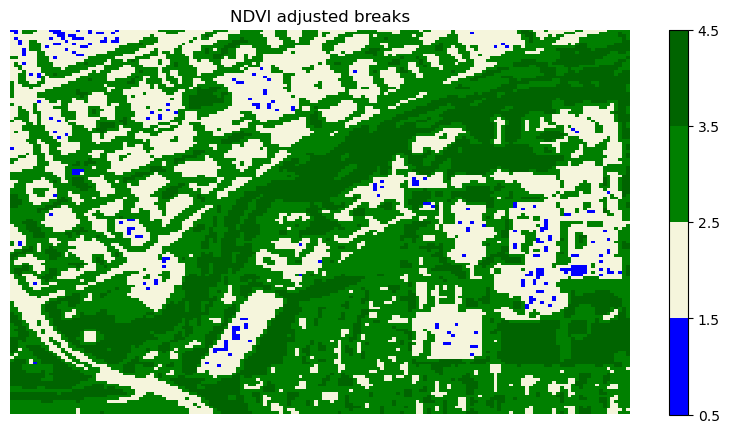

In [58]:
f, ax = plt.subplots(figsize=(10, 5))
ndvi_adjusted.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="NDVI adjusted breaks")
ax.set_axis_off()
plt.show()

**Write a few sentences of what you observe. Where does this classification scheme do well? Where does it not do well? Think of what you see walking around campus and how it compares to the map you generated.** 

This classification scheme is good at demonstrating visually where there is extreme vegetation, low vegetation, urban areas, and water present. This map doesn't break down percentages or show high resolution imagery. I think this map generated what LMU's campus looks like pretty well. I can see pathways and buildings as I know them to be in real life, grassy areas that are accurate. I don't necessarily think the water present section reflects campus. There is more water sections than I think there are in real life on campus. 

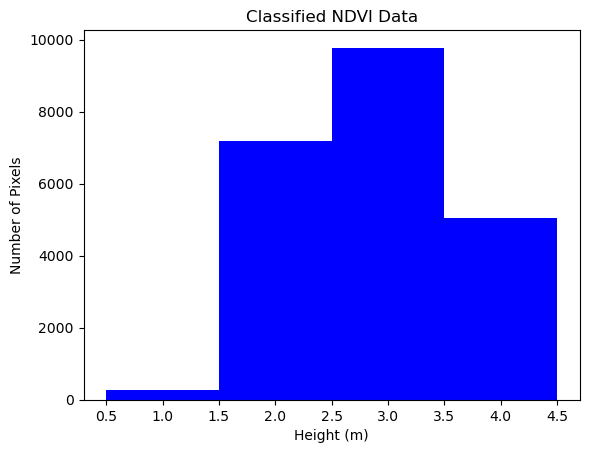

In [65]:
#Create a histogram
f, ax = plt.subplots()
ndvi_adjusted.plot.hist(color="blue",
                        bins=[0.5,1.5,2.5,3.5,4.5])
ax.set(title="Classified NDVI Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

**My Percentage breakdown**

5% Water
   
   20% Urban/Barren
   
   60% Low Vegetation
   
   15% High Vegetation